In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Importing the Libraries.
import keras
import os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
#import keras.backend as K
import tensorflow.keras.backend as K
import tensorflow.compat.v1 as tf
from os import listdir
from os.path import isfile, join
import numpy as np
import sys
import os
import shutil
import pandas as pd
from PIL import Image
import cv2
import keras
import glob
from PIL import Image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from keras import models, regularizers, layers, optimizers, losses, metrics
from keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, MaxPool2D
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import AveragePooling2D
from keras.models import load_model
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from PIL import ImageFile

tf.enable_eager_execution()

In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
# Data Augmentation.
DataGenerator = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rescale=1./255, brightness_range=[0.2,0.7])

In [ ]:
TestGenerator = ImageDataGenerator(rescale=1./255)

In [ ]:
Grey_TrainingData = DataGenerator.flow_from_directory('/content/drive/My Drive/1-piece/Train/', target_size=(224,224), batch_size=8, color_mode='grayscale')

Found 2015 images belonging to 112 classes.


In [ ]:
Grey_ValidData = TestGenerator.flow_from_directory('/content/drive/My Drive/1-piece/Valid/', target_size=(224,224),batch_size=8, color_mode='grayscale')

Found 112 images belonging to 112 classes.


In [ ]:
gpu_options = tf.GPUOptions(allow_growth=True)
session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

In [ ]:
from keras.applications.inception_v3 import InceptionV3

In [ ]:
conv_base = InceptionV3(weights = 'imagenet', include_top = False, pooling = 'avg')

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
for layer in conv_base.layers[:299]:
  layer.trainable = False
for layer in conv_base.layers[299:]:
  layer.trainable = True
for layer in conv_base.layers:
  if isinstance(layer, BatchNormalization):
    layer.trainable = True

print("Done")

Done


In [ ]:
for i, layer in enumerate(conv_base.layers):
   print(i, layer.name, layer.trainable)

0 input_1 False
1 conv2d False
2 batch_normalization True
3 activation False
4 conv2d_1 False
5 batch_normalization_1 True
6 activation_1 False
7 conv2d_2 False
8 batch_normalization_2 True
9 activation_2 False
10 max_pooling2d False
11 conv2d_3 False
12 batch_normalization_3 True
13 activation_3 False
14 conv2d_4 False
15 batch_normalization_4 True
16 activation_4 False
17 max_pooling2d_1 False
18 conv2d_8 False
19 batch_normalization_8 True
20 activation_8 False
21 conv2d_6 False
22 conv2d_9 False
23 batch_normalization_6 True
24 batch_normalization_9 True
25 activation_6 False
26 activation_9 False
27 average_pooling2d False
28 conv2d_5 False
29 conv2d_7 False
30 conv2d_10 False
31 conv2d_11 False
32 batch_normalization_5 True
33 batch_normalization_7 True
34 batch_normalization_10 True
35 batch_normalization_11 True
36 activation_5 False
37 activation_7 False
38 activation_10 False
39 activation_11 False
40 mixed0 False
41 conv2d_15 False
42 batch_normalization_15 True
43 activatio

In [ ]:
from keras.layers import Input 

In [ ]:
input_tensor = Input(shape=(224,224,1))
x = Conv2D(3,(3,3), padding='same')(input_tensor)

In [ ]:
x = conv_base(x)

In [ ]:
x = Dense(2048, activation='relu', kernel_regularizer= regularizers.l2(0.001))(x)
x = Dropout(0.5)(x)

In [ ]:
ouput = Dense(112, activation='softmax')(x)

In [ ]:
model = Model(inputs = input_tensor, outputs = ouput )

In [ ]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 224, 224, 3)       30        
_________________________________________________________________
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 2048)              4196352   
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 112)               229488    
Total params: 26,228,654
Trainable params: 4,836,302
Non-trainable params: 21,392,352
__________________________________

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("/content/drive/My Drive/1-piece/Inceptionv3_GrayScale.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 40,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 40,
                              verbose = 1,
                              min_delta = 0.00001)

callBacks = [earlystop, checkpoint, reduce_lr]

In [ ]:
hist = model.fit_generator(steps_per_epoch=252,generator= Grey_TrainingData, validation_data= Grey_ValidData, validation_steps=14,epochs=150,callbacks=callBacks)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/150
252/252 [==============================] - ETA: 0s - loss: 6.1368 - accuracy: 0.0223
Epoch 00001: val_loss improved from inf to 4.88483, saving model to /content/drive/My Drive/1-piece/Inceptionv3_GrayScale.h5
252/252 [==============================] - 775s 3s/step - loss: 6.1368 - accuracy: 0.0223 - val_loss: 4.8848 - val_accuracy: 0.0804
Epoch 2/150
252/252 [==============================] - ETA: 0s - loss: 4.6676 - accuracy: 0.0491
Epoch 00002: val_loss improved from 4.88483 to 4.03751, saving model to /content/drive/My Drive/1-piece/Inceptionv3_GrayScale.h5
252/252 [==============================] - 92s 364ms/step - loss: 4.6676 - accuracy: 0.0491 - val_loss: 4.0375 - val_accuracy: 0.1161
Epoch 3/150
252/252 [==============================] - ETA: 0s - loss: 4.0528 - accuracy: 0.0824
Epoch 00003: val_loss improved from 4.03751 to 3.93330, saving model to /content/drive/My Drive/1-piece/Inception

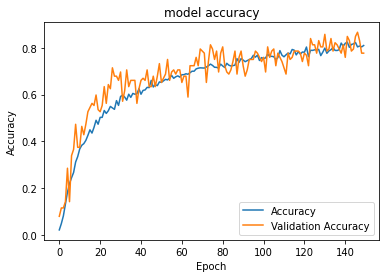

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()

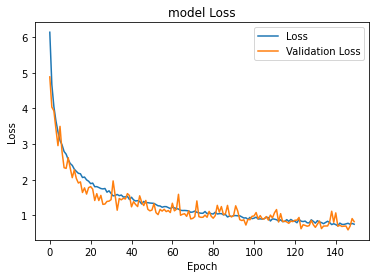

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()

In [ ]:
GreyTestData = TestGenerator.flow_from_directory('/content/drive/My Drive/1-piece/Test/', target_size=(224,224), batch_size = 8, shuffle = False, color_mode='grayscale')

Found 112 images belonging to 112 classes.


In [ ]:
Grey_predict = model.predict(GreyTestData)

In [ ]:
Grey_predict_classes = np.argmax(Grey_predict, axis=1)

In [ ]:
Grey_predict_classes

array([ 24,  29,  29,  21,   4,  24,  24,   7,   9,  10,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        29,  27,  17,  29,  30,  24,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  48,  48,  49,  50,  67,
        52,  53,  54,  55,  56,  57,  68,  59,  60,  61,  51,  77,  64,
        67,  66,  67,  68,  69,  70,  71,  72, 108,  74,  75,  76,  76,
        78,  79,  80,  81,  82,  83,  84,  85,  85,  87,  88,  89,  66,
        91,  92,  93,  94,  95,  96,  97,  98, 100, 100, 101,  66, 103,
        74, 105,  59, 107, 108, 109, 110, 111])

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score

In [ ]:
Grey_accuracy = accuracy_score(GreyTestData.classes, Grey_predict_classes)
print("Grey Accuracy: ", Grey_accuracy)

Grey Accuracy:  0.7767857142857143


In [ ]:
Grey_precision = precision_score(GreyTestData.classes, Grey_predict_classes,average="weighted")
print("Grey Precision: ", Grey_precision)

Grey Precision:  0.7019345238095237


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
Grey_recall = recall_score(GreyTestData.classes, Grey_predict_classes, average="weighted")
print("Grey Recall:", Grey_recall)

Grey Recall: 0.7767857142857143


In [ ]:
Grey_f1_score = f1_score(GreyTestData.classes, Grey_predict_classes, average="weighted")
print("F1 score for Grey: ", Grey_f1_score)

F1 score for Grey:  0.7238095238095238


**Processing for colour Data.**

In [ ]:
Colour_TrainingData =  DataGenerator.flow_from_directory('/content/drive/My Drive/1-piece/Train/', target_size=(224,224), batch_size=8)

Found 2015 images belonging to 112 classes.


In [ ]:
Colour_ValidData =  DataGenerator.flow_from_directory('/content/drive/My Drive/1-piece/Valid/', target_size=(224,224), batch_size=8)

Found 112 images belonging to 112 classes.


In [ ]:
conv_base_colour = InceptionV3(weights = 'imagenet', include_top = False, pooling = 'avg')

In [ ]:
for layer in conv_base_colour.layers[:299]:
  layer.trainable = False
for layer in conv_base_colour.layers[299:]:
  layer.trainable = True
for layer in conv_base_colour.layers:
  if isinstance(layer, BatchNormalization):
    layer.trainable = True

print("Done")

Done


In [ ]:
for i, layer in enumerate(conv_base_colour.layers):
   print(i, layer.name, layer.trainable)

0 input_3 False
1 conv2d_95 False
2 batch_normalization_94 True
3 activation_94 False
4 conv2d_96 False
5 batch_normalization_95 True
6 activation_95 False
7 conv2d_97 False
8 batch_normalization_96 True
9 activation_96 False
10 max_pooling2d_4 False
11 conv2d_98 False
12 batch_normalization_97 True
13 activation_97 False
14 conv2d_99 False
15 batch_normalization_98 True
16 activation_98 False
17 max_pooling2d_5 False
18 conv2d_103 False
19 batch_normalization_102 True
20 activation_102 False
21 conv2d_101 False
22 conv2d_104 False
23 batch_normalization_100 True
24 batch_normalization_103 True
25 activation_100 False
26 activation_103 False
27 average_pooling2d_9 False
28 conv2d_100 False
29 conv2d_102 False
30 conv2d_105 False
31 conv2d_106 False
32 batch_normalization_99 True
33 batch_normalization_101 True
34 batch_normalization_104 True
35 batch_normalization_105 True
36 activation_99 False
37 activation_101 False
38 activation_104 False
39 activation_105 False
40 mixed0 False
41 

In [ ]:
from keras.layers import Input 

In [ ]:
input_tensor = Input(shape=(224,224,3))
x = conv_base_colour(input_tensor)

In [ ]:
x = Dense(2048, activation='relu', kernel_regularizer= regularizers.l2(0.001))(x)
x = Dropout(0.5)(x)

In [ ]:
ouput = Dense(112, activation='softmax')(x)

In [ ]:
colour_model = Model(inputs = input_tensor, outputs = ouput )

In [ ]:
colour_model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("/content/drive/My Drive/1-piece/Colour_InceptionV3.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 40,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 40,
                              verbose = 1,
                              min_delta = 0.00001)

callBacks = [earlystop, checkpoint, reduce_lr]

In [ ]:
hist = colour_model.fit_generator(steps_per_epoch=252,generator= Colour_TrainingData, validation_data= Colour_ValidData, validation_steps=14,epochs=150,callbacks=callBacks)

Epoch 1/150
252/252 [==============================] - ETA: 0s - loss: 6.0946 - accuracy: 0.0293
Epoch 00001: val_loss improved from inf to 4.70998, saving model to /content/drive/My Drive/1-piece/Colour_InceptionV3.h5
252/252 [==============================] - 90s 357ms/step - loss: 6.0946 - accuracy: 0.0293 - val_loss: 4.7100 - val_accuracy: 0.0804
Epoch 2/150
252/252 [==============================] - ETA: 0s - loss: 4.5412 - accuracy: 0.0779
Epoch 00002: val_loss improved from 4.70998 to 3.51492, saving model to /content/drive/My Drive/1-piece/Colour_InceptionV3.h5
252/252 [==============================] - 90s 356ms/step - loss: 4.5412 - accuracy: 0.0779 - val_loss: 3.5149 - val_accuracy: 0.2679
Epoch 3/150
252/252 [==============================] - ETA: 0s - loss: 3.8182 - accuracy: 0.1494
Epoch 00003: val_loss improved from 3.51492 to 2.69684, saving model to /content/drive/My Drive/1-piece/Colour_InceptionV3.h5
252/252 [==============================] - 90s 355ms/step - loss: 3

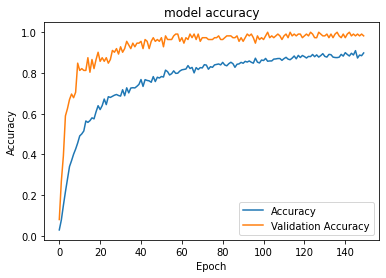

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()

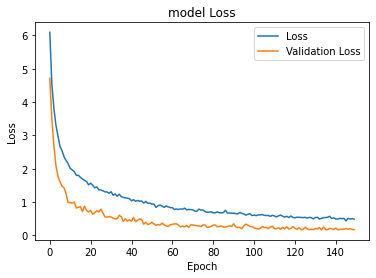

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()

In [ ]:
Colour_TestData = TestGenerator.flow_from_directory('/content/drive/My Drive/1-piece/Test/', target_size=(224,224), batch_size = 8, shuffle = False)

Found 112 images belonging to 112 classes.


In [ ]:
Colour_predict = colour_model.predict(Colour_TestData)

In [ ]:
Colour_predict_classes = np.argmax(Colour_predict, axis=1)

In [ ]:
Colour_predict_classes

array([  0,   1,  15,   3,   4,   5,   6,   7,   6,   9,  10,  11,  12,
        14,  14,  15,  16,  23,  19,  19,  20,  21,  13,  23,  24,  25,
        26,  27,  28,  27,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  51,  46,  47,  47,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  51,  63,  64,
        67,  66,  67,  68,  69,   1,  71,  98,  73,  74,  98,  76,  77,
       108,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  93,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,  52,
       104, 105, 106, 107, 108, 109, 110, 111])

In [ ]:
Colour_accuracy = accuracy_score(Colour_TestData.classes, Colour_predict_classes)
print("Colour Accuracy: ", Colour_accuracy)

Colour Accuracy:  0.8482142857142857


In [ ]:
Colour_precision = precision_score(Colour_TestData.classes, Colour_predict_classes,average="weighted")
print("Colour Precision: ", Colour_precision)

Colour Precision:  0.7827380952380951


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
Colour_recall = recall_score(Colour_TestData.classes, Colour_predict_classes, average="weighted")
print("Colour Recall:", Colour_recall)

Colour Recall: 0.8482142857142857


In [ ]:
Colour_f1_score = f1_score(Colour_TestData.classes, Colour_predict_classes, average="weighted")
print("F1 score for colour: ", Colour_f1_score)

F1 score for colour:  0.8035714285714286


**Emsemble**

In [ ]:
Final = 0.6* Colour_predict + 0.4* Grey_predict

In [ ]:
Final_Predict_classes = np.argmax(Final, axis=1)

In [ ]:
Final_Predict_classes

array([  0,   1,  15,   3,   4,   5,   6,   7,   6,   9,  10,  11,  12,
        14,  14,  15,  16,  17,  19,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  27,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  51,  63,  64,
        67,  66,  67,  68,  69,  70,  71,  98,  73,  74,  98,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  93,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111])

In [ ]:
Final_accuracy = accuracy_score(Colour_TestData.classes, Final_Predict_classes)
print("Colour Accuracy: ", Final_accuracy)

Colour Accuracy:  0.9107142857142857


In [ ]:
Final_precision = precision_score(Colour_TestData.classes, Final_Predict_classes,average="weighted")
print("Colour Precision: ", Final_precision)

Colour Precision:  0.8690476190476192


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
Final_recall = recall_score(Colour_TestData.classes, Final_Predict_classes, average="weighted")
print("Colour Recall:", Final_recall)

Colour Recall: 0.9107142857142857


In [ ]:
Final_f1_score = f1_score(Colour_TestData.classes, Final_Predict_classes, average="weighted")
print("F1 score for colour: ", Final_f1_score)

F1 score for colour:  0.8824404761904763


In [ ]:
Second_Final = 0.5* Colour_predict + 0.5 * Grey_predict

In [ ]:
Second_predict_classes = np.argmax(Second_Final, axis=1)

In [ ]:
Second_predict_classes

array([  0,   1,  15,   3,   4,   5,   6,   7,   6,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  17,  27,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  51,  63,  64,
        67,  66,  67,  68,  69,  70,  71,  72,  73,  74,  98,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98, 100, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111])

In [ ]:
Second_Final_accuracy = accuracy_score(Colour_TestData.classes, Second_predict_classes)
Second_Final_accuracy

0.9285714285714286